In [4]:
import sys
sys.path.append('./')

In [ ]:
import gensim
import pandas as pd
from constants import PROCESSED_DF_PATH, MUESTRA_DS_PATH
from sklearn.model_selection import train_test_split
from utils import topn_most_similar_plot, path_exists, path_concat, model_exists
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from collections import Counter
from sklearn.metrics import classification_report
from transformers import BertModel, BertTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\aleja\anaconda3\envs\NLPEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Embeddings con WORD2VEC

In [11]:
# Leemos nuestro dataset ya procesado
df = pd.read_csv(PROCESSED_DF_PATH)

In [413]:
# Definimos el nombre del modelo y la ruta
WORD2VEC_MODEL_NAME = 'word2vec.model'
WORD2VEC_MODEL_PATH = path_concat('./Models/DeepLearning', WORD2VEC_MODEL_NAME)

# Separamos por tokens(palabras)
texts = df['text'].str.split(' ')

# Verificamos si el modelo existe y lo cargamos
if path_exists(WORD2VEC_MODEL_PATH):
    model = gensim.models.Word2Vec.load(WORD2VEC_MODEL_PATH)

# Sino lo instanciamos y le pasamos el corpus
else:
    model = gensim.models.Word2Vec(
        sentences=texts, 
        vector_size=100, 
        window=5, 
        min_count=3, 
        sg=1,
        negative=10,
        epochs=30
    )
        
    model.save(WORD2VEC_MODEL_PATH)

Usaremos un modelo SKIP-GRAM, ya que su arquitectura esta diseñada para que de acuerdo a la palabra conozcamos su posible contexto en el que estaría.

In [414]:
model.wv.most_similar('nvidia')

[('ati', 0.7573493719100952),
 ('geforce', 0.7080509066581726),
 ('radeon', 0.6703972816467285),
 ('gtx', 0.6577612161636353),
 ('radeontm', 0.651879072189331),
 ('quadro', 0.6351732611656189),
 ('pciexpress', 0.6225249767303467),
 ('ram', 0.6211874485015869),
 ('gddr', 0.606654167175293),
 ('intel', 0.5935372114181519)]

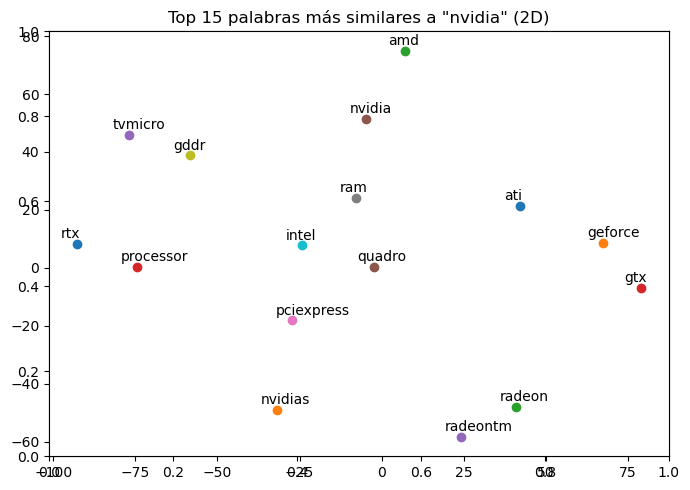

In [415]:
# Vamos a utilizar una función para ver en un plano 2D una representación de distancia de n palabras más similares para una palabra x
topn_most_similar_plot('nvidia', model, topn=15, ndim=2)

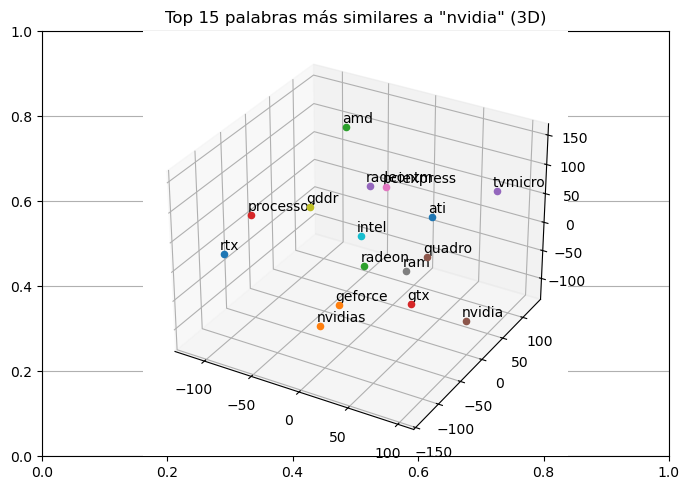

In [416]:
# Ahora en un plano 3D, para ello usaremos, el algoritmo de reducción de dimensionalidad TSN-E que es perfecto para visualización de datos
topn_most_similar_plot('nvidia', model, topn=15, ndim=3)

# Implementación de una red LSTM para clasificación


In [ ]:
# Definimos las categorias en el orden en el que las codificamos
labels = ["Bueno", "Malo", "Neutral"]

In [2]:
# Creamos una función para escribir el vocabulario
def build_vocab(texts, min_freq=3):
    """
        Toma un corpus de texto y va iterando sobre cada oración contando la frecuencia de cada una de las palabras
        De acuerdo a ello la mete o no en el vocabulario, para la creación del vocabulario crea una dict Palabra: índice 
    Args:
        texts (list): List de oraciones
        min_freq (int, optional): Frecuencia mínima de aparición de una palabra para ser incluida en el vocabulario. Predeterminado 3.

    Returns:
        dict: Con el vocabulario
    """
    counter = Counter()
    
    # Iteramos por cada oración
    for text in texts:
        # Lo separamos por espacios
        tokens = text.split()
        
        # Realizamos el conteo
        counter.update(tokens)
    
    # Definimos la variable vocab que será nuestro diccionario
    # Tiene los valores de PAD que nos servirá como padding y UNK para palabras desconocidas
    vocab = {'<PAD>': 0, '<UNK>': 1}
    
    # El indice comienza en 2
    index = 2
    
    # Ahora iteramos por el contador
    for word, freq in counter.items():
        # Si la palabra cumple el umbral mínimo de aparición se agrega al diccionario
        if freq >= min_freq:
            vocab[word] = index
            index += 1
            
    return vocab


In [5]:
def text_encoder(sentence, vocab, max_length=128):
    """
        Esta función utiliza un vocabulario y codifica las palabras
    Args:
        sentence (string): Oración a codificar
        vocab (dict): El vocabulario a usar para la codificación
        max_length (int): Largo máximo de todas las oraciones. Predeterminado 128.

    Returns:
        _type_: _description_
    """
    tokens = sentence.split()
    
    word_indexs = [vocab.get(word, vocab['<UNK>']) for word  in tokens]
    
    if len(word_indexs) < max_length:
        word_indexs += [vocab['<PAD>']] * (max_length - len(word_indexs))
    else:
        word_indexs = word_indexs[:max_length]
        
    return word_indexs

In [ ]:
# Vamos a crear la clase dataset que usaremos
class TextDataset(Dataset):
    # Usaremos esta clase de dataset para dos modelos diferentes por lo que tendrá el p·arámetro type para saber a que modelo nos referimos
    def __init__(self, texts, labels, type, vocab=None, max_length= 128):
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.type = type
        self.vocab = vocab
        self.max_length = max_length
    
    # Vamos a definir el comportamiento del método especial len
    def __len__(self):
        return len(self.texts)
    
    # Ahora el comportamiento al obtener un elemento
    def __getitem__(self, index):
        # Ambos comparten text y label
        text = self.texts[index]
        label = self.labels[index]

        # Si es para el modelo que usa bert usaremos su tokenizador y su output va con la capa de atención
        if self.type == 'bert':
            encoded_text = BertTokenizer.from_pretrained('bert-base-uncased')(text,
                            return_tensors='pt',
                            padding='max_length',
                            truncation=True,
                            max_length=self.max_length)

            output = {
                "input_ids": encoded_text['input_ids'].squeeze(0),
                'attention_mask' : encoded_text['attention_mask'].squeeze(0),
                "labels": torch.tensor(label, dtype=torch.long),
            }
            
        else: 
        
        # En cambio si el modelo que usa una red LSTM usamos nuestro codificador personalizado
            encoded_text = text_encoder(text,
                                        self.vocab, 
                                        self.max_length)

            output = {
                "input_ids": torch.tensor(encoded_text, dtype=torch.long),
                "labels": torch.tensor(label, dtype=torch.long),
            }
        
        return output

In [ ]:
# También vamos a definir una clase EarlyStopping para evitar entrenamiento bruto
class EarlyStopping():
    def __init__(self, patience=3, delta=0):
      self.patience = patience
      self.delta = delta
      self.best_loss = None
      self.counter = 0
      self.early_stop = False

    def __call__(self, val_loss):
      if self.best_loss is None:
        self.best_loss = val_loss

      elif val_loss < self.best_loss - self.delta:
        self.best_loss = val_loss
        self.counter = 0

      else:
        self.counter += 1

      if self.counter >= self.patience:
        self.early_stop = True

In [ ]:
# Ahora vamos a definir nuestro primera clase para el primer modelo
# Heredamos de la clase nn.Module de torch
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hiddem_dim, num_classes, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx) # Capa de embedding
        self.lstm = nn.LSTM(embed_dim, hiddem_dim, batch_first=True) # La capa LSTM
        self.linear1 = nn.Linear(hiddem_dim, hiddem_dim // 2) # Primera capa lineal
        self.linear2 = nn.Linear(hiddem_dim // 2, hiddem_dim // 4) # Segunda capa lineal
        self.linear3 = nn.Linear(hiddem_dim // 4, num_classes) # Tercera capa lineal y clasificadora
        self.norm_layer = nn.LayerNorm(hiddem_dim // 2) # Capa normlizadora
        self.dropout = nn.Dropout(dropout) # Capa de DropOut
        self.relu = nn.ReLU() # Capa de activación ReLU
    
    # Definimos el comportamiento cuando se llame al modelo
    def forward(self, input_ids):
        # Pasamos el texto codificado por la capa de embedding
        x = self.embedding_layer(input_ids)
        # La pasamos por la capa LSTM y tomamos su estado oculto
        _, (hidden, _) = self.lstm(x)
        
        # Ahora pasamos a la primera capas densas
        x = self.linear1(hidden[-1])
        x = self.norm_layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Segunda capa densa
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Capa de clasificación
        logits = self.linear3(x)
        
        return logits

In [12]:
# Separamos en sets para train, test y val
X = df['text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# Construimos el vocabulario
vocab = build_vocab(X_train, 5)

# Intanciamos los dataset
train_ds_lstm = TextDataset(X_train.tolist(), y_train.tolist(), 'lstm', vocab=vocab, max_length=128)
test_ds_lstm = TextDataset(X_test.tolist(), y_test.tolist(), 'lstm', vocab=vocab, max_length=128)
val_ds_lstm = TextDataset(X_val.tolist(), y_val.tolist(), 'lstm', vocab=vocab, max_length=128)

# Usamos un DataLoader de torch para entregar la información por batches 
train_loader_lstm = DataLoader(train_ds_lstm, batch_size=32, shuffle=True)
test_loader_lstm = DataLoader(train_ds_lstm, batch_size=32,  shuffle=True)
val_loader_lstm = DataLoader(train_ds_lstm, batch_size=32,  shuffle=True)

In [ ]:
# Parametros para el primer modelo
VOCAB_SIZE = len(vocab)
EMBED_DIN = 128
HIDDEN_DIM = 64
PAD_IDX = vocab['<PAD>']
NUM_CLASSES = 3
LEARNING_RATE = 1e-3

# Función de perdida
loss_funct = CrossEntropyLoss()

# Instancia del modelo
lstm_classifier_model = LSTMClassifier(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIN, hiddem_dim=HIDDEN_DIM, pad_idx=PAD_IDX, num_classes=NUM_CLASSES)

# Optimizador
optimizer = torch.optim.Adam(
    lstm_classifier_model.parameters(),
    lr = LEARNING_RATE
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

lstm_classifier_model.to(device)

LSTMClassifier(
  (embedding_layer): Embedding(15656, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=3, bias=True)
  (norm_layer): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [ ]:
EPOCHS_LSTM = 25
LSTM_CLASSIFIER_NAME = 'lstm_classifier.pth'
LSTM_CLASSIFIER_PATH = path_concat('./Models/DeepLearning/', LSTM_CLASSIFIER_NAME)

# Entrenamos el modelo en caso de que no lo tengamos guardado, sino simplemente lo cargamos
if model_exists(LSTM_CLASSIFIER_NAME, 'dl'):
    lstm_classifier_model.load_state_dict(torch.load(LSTM_CLASSIFIER_PATH, weights_only=True))
    lstm_classifier_model.to(device)
    lstm_classifier_model.eval()
else:
    # Instanciamos el earlystopping con una paciencia de 3
    early_stopping_lstm = EarlyStopping(3)
    
    # Vamos por cada epoca
    for epoch in range(EPOCHS_LSTM):
        
        print(f'Epoch {epoch + 1}/{EPOCHS_LSTM}')
        train_loss = 0
        
        #Ponemos el modelo en modo entrenamiento
        lstm_classifier_model.train()
        
        # Iteramos por cada bache
        for batch in train_loader_lstm:
            
            # Cogemos las variables predictoras
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # Ponemos el optimizamos en 0
            optimizer.zero_grad()
            
            # Tomamos las activaciones de la ultima capa
            logits = lstm_classifier_model(input_ids)
            
            # Calculamos la perdida
            loss = loss_funct(logits, labels)
            
            train_loss += loss.item()
            
            # Realizamos el back-progration
            # Calculamos las derivadas parciales 
            loss.backward()
            # Realizamos los cambios en el modelo
            optimizer.step()
        print('Loss training :', train_loss/len(train_loader_lstm))

        # Ahora vamos a la fase de evaluación
        # Como haremos inferncia no necesitamos calcular los gradientes
        with torch.no_grad():
            # Ponemos el modelo en modo de inferencia
            lstm_classifier_model.eval()
            
            val_loss = 0        
            
            for batch in val_loader_lstm:
                
                text = batch['input_ids']
                labels = batch['labels']
            
                logits = lstm_classifier_model(text)
                
                # Calculamos la perdida para validación
                loss = loss_funct(logits, labels)
                
                val_loss += loss.item()
            
        print('Loss val: ', val_loss/len(val_loader_lstm))
        
        # Le pasamos el valor de val al early stopping
        early_stopping_lstm(val_loss)
            
        # Verificamos si nos da True para activarlo, sino continuamos
        if early_stopping_lstm.early_stop:
            print('Early Stopping Triggered!')
            break
        
    # Una vez terminado el entrenamiento guardamos los pesos del modelo
    torch.save(lstm_classifier_model.state_dict(), LSTM_CLASSIFIER_PATH)
    lstm_classifier_model.to(device)
    lstm_classifier_model.eval()

In [ ]:
# Vamos a probar el modelo
all_pred = []
all_labels = []

for batch in train_loader_lstm:
    text = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    with torch.no_grad():
        logits = lstm_classifier_model(text)
    
    pred = torch.argmax(logits, dim=1)
    all_pred.extend(pred.cpu().tolist())
    all_labels.extend(labels.cpu().tolist())


In [ ]:
# Veamos sus métricas
print(classification_report(all_labels, all_pred, target_names=labels))

              precision    recall  f1-score   support

       Bueno       0.35      0.71      0.47     41519
        Malo       0.39      0.39      0.39     43775
     Neutral       0.88      0.04      0.07     44092

    accuracy                           0.37    129386
   macro avg       0.54      0.38      0.31    129386
weighted avg       0.54      0.37      0.31    129386



# Uso de BERT

In [ ]:
# Definimos la clase para el clasificador que hará uso de BERT
class BertClassifier(nn.Module):
  def __init__(self, bert_type='bert-base-uncased', num_classes=3, dropout_rate=0.3):
    super().__init__()
    self.bert = BertModel.from_pretrained(bert_type) # Cargamos BERT pre entrenado
    self.linear_1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2) # Primera capa lineal
    self.linear_2 = nn.Linear(self.bert.config.hidden_size // 2, self.bert.config.hidden_size // 4) # Segunda capa lineal
    self.linear_3 = nn.Linear(self.bert.config.hidden_size // 4, num_classes) # Tercera capa lineal y clasificador
    self.relu = nn.ReLU() # Capa de activación ReLU
    self.dropout = nn.Dropout(dropout_rate) # Capa de DROPOUT
    self.LayerNorm = nn.LayerNorm(self.bert.config.hidden_size // 2) # Capa de normalización
    self.num_classes = num_classes # Número de clases
    self.loss_funct = CrossEntropyLoss() # Función de perdida

  # Definimos su comportamiento al ser llamado
  def forward(self, input_ids, attention_mask, labels = None):
    # Pasamos los valores necesarios a BERT
    input = self.bert(input_ids=input_ids, attention_mask = attention_mask)

    # Tomamos el ultimo estado oculto
    x = input.last_hidden_state[:, 0]

    # Le pasamos el estado oculto a la primera capa
    x = self.linear_1(x)
    x = self.LayerNorm(x)
    x = self.relu(x)
    x = self.dropout(x)

    # Segunda capa
    x = self.linear_2(x)
    x = self.relu(x)
    x = self.dropout(x)

    # Tomamos las activaciones de la capa final
    logits = self.linear_3(x)

    
    isLabelsNone = labels is not None
    if isLabelsNone:
      # Calculamos la perdida
      loss = self.loss_funct(logits.view(-1, self.num_classes), labels.view(-1))

    # Devolvemos la perdida y los logits
    return (logits, loss) if isLabelsNone else logits
  

In [ ]:
# En este caso usaremos el dataset del muestreo sin haberlo pre procesado, ya que el tokenizador de bert se encargará de eso
df_raw = pd.read_json(MUESTRA_DS_PATH, lines=True)

In [ ]:
# Definimos las categorias para realizar el mapeo
categories = {
    "Bueno": 0,
    "Malo": 1,
    "Neutral":2
}
# Separamos en train,test y val
X = df_raw['text']
y = df_raw['category'].map(categories)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2 ,shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=.2,shuffle=True)

train_ds_bert = TextDataset(X_train.tolist(), y_train.tolist(), type='bert')
test_ds_bert = TextDataset(X_test.tolist(), y_test.tolist(), type='bert')
val_ds_bert = TextDataset(X_val.tolist(), y_val.tolist(), type='bert')

train_loader_bert = DataLoader(train_ds_bert, batch_size=32, shuffle=True)
test_loader_bert = DataLoader(test_ds_bert, batch_size=32, shuffle=True)
val_loader_bert = DataLoader(val_ds_bert, batch_size=32, shuffle=True)

In [58]:
LEARNING_RATE = 1e-3
# Instancia de BERT
bert_classifier = BertClassifier()

# Congelamos todas las capas de BERT
for param in bert_classifier.bert.parameters():
    param.requires_grad = False
    
# Descongelamos las demás capas de BERT para realizar un fine-tuning excepto las capaz encargadas de realizar los embeddings
for name, param in bert_classifier.bert.named_parameters():
    if not name.startswith("embeddings"):
        param.requires_grad = True
    
# Definimos el optimizador
optimizer = torch.optim.AdamW([
        {'params': bert_classifier.linear_1.parameters()},
        {'params': bert_classifier.LayerNorm.parameters()},
        {'params': bert_classifier.linear_2.parameters()},
    ], lr=LEARNING_RATE)

In [ ]:
BERT_MODEL_NAME = 'bert_classifier_weights.pth'
BERT_MODEL_PATH = path_concat('./Models/DeepLearning/', BERT_MODEL_NAME)
EPOCHS = 5
# Creamos el modelo en caso de que no exista, sino solo lo cargamos
if model_exists(BERT_MODEL_NAME, 'dl'):
    bert_classifier.load_state_dict(torch.load(BERT_MODEL_PATH, weights_only=True, map_location=device))
    bert_classifier.to(device)
    bert_classifier.eval()
else:
  # Definimos el early stopping
    early_stopping = EarlyStopping(3)
    bert_classifier.to(device)
    
    # Entrenamos el modelo
    for epoch in range(EPOCHS):
      print(f"Epoch {epoch + 1}/{EPOCHS}")
      
      # Lo ponemos en modo entrenamiento
      bert_classifier.train()
      total_loss = 0

      # Iteramos por el DataLoader de train
      for batch in train_loader_bert:
        
        # Tomamos las features
        inputs_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Gradientes a 0 
        optimizer.zero_grad()

        # Tomamos el output
        outputs = bert_classifier(inputs_ids, attention_mask, labels)

        # Cogemos solo el loss
        _, loss = outputs

        total_loss += loss.item()

        # Relizamos backpropagation
        loss.backward()

        optimizer.step()

      avg_loss = total_loss / len(train_loader_bert)
      print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {avg_loss:.4f}")

      # Lo ponemos en modo entrenamiento para realizar la evaluación
      with torch.no_grad():
        bert_classifier.eval()
        val_loss = 0
        # Vamos iterando por el set de val
        for batch in val_loader_bert:
          inputs_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = bert_classifier(inputs_ids, attention_mask, labels)
          _, loss = outputs
          # Vamos calculando y sumando las perdidas
          val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader_bert)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Validation Loss: {avg_val_loss:.4f}")

        # Llamamos al early stopping
        early_stopping(avg_val_loss)

        # Vemos en caso de que haya que activarlo
        if early_stopping.early_stop:
          print("Early stopping triggered!")
          break
        
    torch.save(bert_classifier.state_dict(), BERT_MODEL_PATH)
    bert_classifier.eval()

In [ ]:
# Probamos el modelo
all_pred = []
all_labels = []

for batch in train_loader_bert:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device).to(device)
    
    with torch.no_grad():
        logits = bert_classifier(input_ids=input_ids, attention_mask=attention_mask) 
    
    pred = torch.argmax(logits, dim=1)
    all_pred.extend(pred.cpu().tolist())
    all_labels.extend(labels.cpu().tolist())


In [ ]:
classification_report(all_labels, all_pred, target_names=labels)

Veo que los modelos funcionan de manera extraña, a pesar de que la definición de clases es correcta, lamentablemente debido al costo computacional que conlleva su entrenamiento no puedo realizar más pruebas con ellos para encontrar mejores resultados.

Por lo que sin haber ido más allá me tendría que quedar con los modelos de machine learning, siendo más específico con el más simple que usé que fue la regresión logística multiclase, pero sé que estos modelos de DeepLearning me podrían haber dado mejores resultados.